# Model Calibration

Calibrating the Displaced - Diffusion and SABR models to SPX and SPY options market implied volatilities using 1 Dec 2020 bid prices for respective strikes with maturities of 18 Dec 2020, 15 Jan 2021 and 19 Feb 2021. 

Market implied volatilities are calculated assuming Black-Scholes as the reporting model.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import datetime as dt

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

In [2]:
def BlackScholesCall(S, sigma, K, r, T):
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T) / (np.sqrt(T) * sigma)
    d2 = d1 - np.sqrt(T) * sigma
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [3]:
def BlackScholesPut(S, sigma, K, r, T):
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T) / (np.sqrt(T) * sigma)
    d2 = d1 - np.sqrt(T) * sigma
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

### Import Dataset

<pre>
SPX_options   |:    Bid & Offer prices of 1 Dec 2020 SPX options at various strikes and maturities (European)
SPY_options   |:    Bid & Offer prices of 1 Dec 2020 SPY options at various strikes and maturities (American)
discount_rates|:    Discount rates on 1 Dec 2020 for nth day ahead
</pre>

Note: Strikes prices given have been multiplied by a factor of 1000 to avoid decimal places for clarity.

In [6]:
SPX_options = pd.read_csv("SPX_options.csv")
SPY_options = pd.read_csv("SPY_options.csv")
discount_rates = pd.read_csv("zero_rates_20201201.csv")

In [7]:
SPX_options.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E


In [8]:
SPX_options["exdate"].unique()

array([20201218, 20210115, 20210219])

In [9]:
SPY_options.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,25000,340.74,341.20,A
1,20201201,20201218,C,50000,315.75,316.21,A
2,20201201,20201218,C,75000,290.75,291.21,A


In [10]:
SPY_options["exercise_style"].unique()

array(['A'], dtype=object)

In [11]:
discount_rates.head(3)

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480


### Data Wrangling

In [12]:
def getImpliedVolatility(S, K, r, T, price, flag):
    try:
        if (flag == "C"):
            return brentq(lambda x: price - BlackScholesCall(S, x, K, r, T), 1e-12, 10)
        elif (flag == "P"):
            return brentq(lambda x: price - BlackScholesPut(S, x, K, r, T), 1e-12, 10)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        return np.nan  

In [13]:
# Discount rates provided are not continuous across the number of days 
# For desired maturities date, discount rates are calculated using linear interpolation
discount_rates["date"] = pd.to_datetime(discount_rates["date"], format = "%Y%m%d")
min = discount_rates["days"].min()
max = discount_rates["days"].max()
discount_rates = discount_rates.set_index("days").reindex(index = list(range(min, max+1)))
discount_rates["rate"] = discount_rates["rate"].interpolate(method='index', limit_direction='forward')
discount_rates["rate"] /= 100
discount_rates = discount_rates.ffill().reset_index()

In [14]:
discount_rates.head(3)

,days,date,rate
0,7,2020-12-01,0.001023
1,8,2020-12-01,0.001043
2,9,2020-12-01,0.001062


### Determining Market Implied Volatilities

Based on the observed market bid and offer prices of the various call and put options over 3 maturities. Option prices for each strike were estimated using the average bid and offer values. Prices were then plugged into Black-Scholes model to derive the implied volatilities. Only volatilities for Out-The-Money (OTM) put and call options were considered for strikes below and above the current index value respectively, as the OTM options are relatively more liquid.

#### Implied Volatility - SPX Options

In [15]:
# Convert date and exdate to datetime format
SPX_options["date"] = pd.to_datetime(SPX_options["date"], format = "%Y%m%d")
SPX_options["exdate"] = pd.to_datetime(SPX_options["exdate"], format = "%Y%m%d")

In [16]:
# Strike price in actual dollar amount
SPX_options["strike_price_actual"] = SPX_options["strike_price"] / 1000

# Option time to expiry
SPX_options["time_expiry"] = (SPX_options["exdate"] - SPX_options["date"]).dt.days

# Option prices based on average of bid-ask
SPX_options["price"] = (SPX_options["best_bid"] + SPX_options["best_offer"]) / 2

# Index value on 1 Dec 2020
SPX_index_val =  3662.45

# Discount rates
SPX_options = SPX_options.merge(discount_rates[["days", "rate"]], left_on = "time_expiry", right_on = "days").drop(["days"], axis = 1)

SPX_options["time_expiry"] /= 365

# Initialize Implied Vol column
SPX_options["implied_vol"] = pd.Series()

In [17]:
# Calculate the implied volatility for each strike price
# Black Scholes model is used as the reporting model

SPX_options["implied_vol"] = SPX_options.apply(lambda row: getImpliedVolatility(SPX_index_val,
                                                                                row["strike_price_actual"],
                                                                                row["rate"],
                                                                                row["time_expiry"],
                                                                                row["price"],
                                                                                row["cp_flag"]),
                                               axis = 1
                                              )

In [18]:
# We use calculated put implied volatility for strikes below current index value
# and calculated call implied volatility for strikes above current index value

impliedvol_SPX = {}

for date in SPX_options["exdate"].unique():
    values = []
    call_df = SPX_options[(SPX_options["exdate"] == date) & (SPX_options["cp_flag"] == "C")]
    put_df = SPX_options[(SPX_options["exdate"] == date) & (SPX_options["cp_flag"] == "P")]
    strikes = put_df["strike_price_actual"].values
    for K in strikes:
        if K < SPX_index_val:
            values.append(put_df[put_df["strike_price_actual"] == K]["implied_vol"].values[0])
        else:
            values.append(call_df[call_df["strike_price_actual"] == K]["implied_vol"].values[0])
    impliedvol = pd.DataFrame({"strike": strikes, "implied_vol": values})
    impliedvol_SPX[date] = impliedvol

In [19]:
SPX_options["exdate"].unique()

<DatetimeArray>
['2020-12-18 00:00:00', '2021-01-15 00:00:00', '2021-02-19 00:00:00']
Length: 3, dtype: datetime64[ns]

In [20]:
impliedvol_SPX[dt.datetime(2021,2,19)]

,strike,implied_vol
0,100.0,2.160100
1,200.0,1.724868
2,300.0,1.477592
3,400.0,1.304969
4,500.0,1.172504
...,...,...
251,5000.0,0.224559
252,5100.0,0.234641
253,5200.0,0.243829
254,5300.0,0.255771


In [21]:
SPX_options.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,strike_price_actual,time_expiry,price,rate,implied_vol
0,2020-12-01,2020-12-18,C,100000,3547.6,3570.5,E,100.0,0.046575,3559.05,0.001255,NaN
1,2020-12-01,2020-12-18,C,200000,3447.6,3470.5,E,200.0,0.046575,3459.05,0.001255,NaN
2,2020-12-01,2020-12-18,C,300000,3347.7,3370.6,E,300.0,0.046575,3359.15,0.001255,NaN


#### Implied Volatility - SPY Options

In [22]:
# Convert date and exdate to datetime format
SPY_options["date"] = pd.to_datetime(SPY_options["date"], format = "%Y%m%d")
SPY_options["exdate"] = pd.to_datetime(SPY_options["exdate"], format = "%Y%m%d")

In [23]:
# Strike price in actual dollar amount
SPY_options["strike_price_actual"] = SPY_options["strike_price"] / 1000

# Option time to expiry
SPY_options["time_expiry"] = (SPY_options["exdate"] - SPY_options["date"]).dt.days

# Option prices based on average of bid-ask
SPY_options["price"] = (SPY_options["best_bid"] + SPY_options["best_offer"]) / 2

# Index value on 1 Dec 2020
SPY_index_val =  366.02

# Discount rates
SPY_options = SPY_options.merge(discount_rates[["days", "rate"]], left_on = "time_expiry", right_on = "days").drop(["days"], axis = 1)

SPY_options["time_expiry"] /= 365

# Initialize Implied Vol column
SPY_options["implied_vol"] = pd.Series()

In [24]:
SPY_options.head(3)

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,strike_price_actual,time_expiry,price,rate,implied_vol
0,2020-12-01,2020-12-18,C,25000,340.74,341.20,A,25.0,0.046575,340.97,0.001255,NaN
1,2020-12-01,2020-12-18,C,50000,315.75,316.21,A,50.0,0.046575,315.98,0.001255,NaN
2,2020-12-01,2020-12-18,C,75000,290.75,291.21,A,75.0,0.046575,290.98,0.001255,NaN


In [25]:
# Calculate the implied volatility for each strike price
# Black Scholes model is used as the reporting model

SPY_options["implied_vol"] = SPY_options.apply(lambda row: getImpliedVolatility(SPY_index_val,
                                                                                row["strike_price_actual"],
                                                                                row["rate"],
                                                                                row["time_expiry"],
                                                                                row["price"],
                                                                                row["cp_flag"]),
                                               axis = 1
                                              )

In [26]:
# We use calculated put implied volatility for strikes below current index value
# and calculated call implied volatility for strikes above current index value

impliedvol_SPY = {}

for date in SPY_options["exdate"].unique():
    values = []
    call_df = SPY_options[(SPY_options["exdate"] == date) & (SPY_options["cp_flag"] == "C")]
    put_df = SPY_options[(SPY_options["exdate"] == date) & (SPY_options["cp_flag"] == "P")]
    strikes = put_df["strike_price_actual"].values
    for K in strikes:
        if K < SPY_index_val:
            values.append(put_df[put_df["strike_price_actual"] == K]["implied_vol"].values[0])
        else:
            values.append(call_df[call_df["strike_price_actual"] == K]["implied_vol"].values[0])
    impliedvol = pd.DataFrame({"strike": strikes, "implied_vol": values})
    impliedvol_SPY[date] = impliedvol

In [27]:
SPY_options["exdate"].unique()

<DatetimeArray>
['2020-12-18 00:00:00', '2021-01-15 00:00:00', '2021-02-19 00:00:00']
Length: 3, dtype: datetime64[ns]

In [28]:
impliedvol_SPY[dt.datetime(2021,2,19)]

,strike,implied_vol
0,165.0,0.637820
1,170.0,0.629293
2,175.0,0.613090
3,180.0,0.601947
4,185.0,0.589661
...,...,...
162,480.0,0.205924
163,485.0,0.216124
164,490.0,0.216147
165,495.0,0.222877


### `Displaced - Diffusion` Model Calibration

Mark Rubenstein's Displaced - Diffusion model has two parameters, namely sigma and beta, to fit to the market implied volatilities curve. Generally, sigma is fitted to the volatility at the At-The-Money (ATM) option, leaving only beta as the free parameter for calibration. Beta is fitted using the least squares algorithm from the Scipy library.

- Sigma represents the volatility of the underlying asset, and higher values indicate greater volatility, reflecting the uncertainty and potential future movements in the underlying asset's price
- Beta controls the extent of the shift between the normal and lognormal process

In [29]:
def calculateATMVolatility(df, S):
    difference = np.abs(df["strike"] - S)
    return df.loc[difference.argmin(), "implied_vol"]

In [30]:
def DisplacedDiffusionCalibration(S, sigma, strikes, r, T, x, vols):
    err = 0.0
    F = np.exp(r*T)*S
    for i, vol in enumerate(vols):
        if strikes[i] > S:
            price = DisplacedDiffusionCall(S, sigma, strikes[i], r, T, x[0])
            flag = "C"
        else:
            price = DisplacedDiffusionPut(S, sigma, strikes[i], r, T, x[0])
            flag = "P"
        err += (vol - getImpliedVolatility(S, strikes[i], r, T, price, flag)) ** 2
    return err

In [4]:
def DisplacedDiffusionCall(S, sigma, K, r, T, beta):
    F = np.exp(r*T)*S
    d1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T) * (F/beta*norm.cdf(d1) - ((1-beta)/beta*F + K)*norm.cdf(d2))

In [5]:
def DisplacedDiffusionPut(S, sigma, K, r, T, beta):
    F = np.exp(r*T)*S
    d1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T) * (((1-beta)/beta*F + K)*norm.cdf(-d2) - F/beta*norm.cdf(-d1))

#### SPX Options

In [31]:
# Get ATM option volatility for each ex-date
ATM_vols_SPX = {}
for date, vols in impliedvol_SPX.items():
    ATM_vols_SPX[date] = calculateATMVolatility(impliedvol_SPX[date], SPX_index_val)

ATM_vols_SPX

{Timestamp('2020-12-18 00:00:00'): 0.17821496231603645,
 Timestamp('2021-01-15 00:00:00'): 0.18886028486801051,
 Timestamp('2021-02-19 00:00:00'): 0.19717431220334597}

In [32]:
# Estimated runtime is 2 minutes
# Fitting beta values using the least sqaures method
# Sigma value has been calibrated to ATM options

initialGuess = [0.5]
limits = [0,1]
option_day = dt.datetime(2020, 12, 1)
beta_DD_SPX = {}

for date, vols in impliedvol_SPX.items():
    days_diff = (date - option_day).days
    res = least_squares(lambda x: DisplacedDiffusionCalibration(SPX_index_val,
                                                                ATM_vols_SPX[date],
                                                                vols["strike"],
                                                                discount_rates.iloc[days_diff - 7]["rate"],
                                                                days_diff/365,
                                                                x,
                                                                vols["implied_vol"]),
                        initialGuess,
                        bounds = limits)
    beta_DD_SPX[date] = res.x[0]

In [33]:
beta_DD_SPX

{Timestamp('2020-12-18 00:00:00'): 1.3245709422729888e-06,
 Timestamp('2021-01-15 00:00:00'): 2.3030551833122773e-07,
 Timestamp('2021-02-19 00:00:00'): 3.9916733313635e-07}

In [34]:
# Calculate implied volatility using DD model pricing
option_day = dt.datetime(2020, 12, 1)
DD_SPX = {}  

for date, vols in impliedvol_SPX.items():
    days_diff = (date - option_day).days
    r = discount_rates.iloc[days_diff - 7]["rate"]
    betas_list_SPX = [0.1, 0.5, beta_DD_SPX[date]]
    betas_SPX_df = pd.DataFrame()

    for beta in betas_list_SPX:
        DD_implied_vols =[]
        for K in vols["strike"]:
            if K > SPX_index_val:
                DD_option_price = DisplacedDiffusionCall(SPX_index_val,
                                                         ATM_vols_SPX[date],
                                                         K,
                                                         r,
                                                         days_diff,
                                                         beta)
                flag = "C"
            else:
                DD_option_price = DisplacedDiffusionPut(SPX_index_val,
                                                        ATM_vols_SPX[date],
                                                        K,
                                                        r,
                                                        days_diff,
                                                        beta)
                flag = "P"
            DD_implied_vols.append(getImpliedVolatility(SPX_index_val,
                                                        K,
                                                        r,
                                                        days_diff,
                                                        DD_option_price,
                                                        flag)
                                  )
        betas_SPX_df[f"beta_{beta:.4f}"] = DD_implied_vols
        
    DD_SPX[date] = pd.concat([vols["strike"], betas_SPX_df],
                             axis = 1)

In [38]:
DD_SPX[dt.datetime(2020,12,18)].columns[1:]

Index(['beta_0.1000', 'beta_0.5000', 'beta_0.0000'], dtype='object')

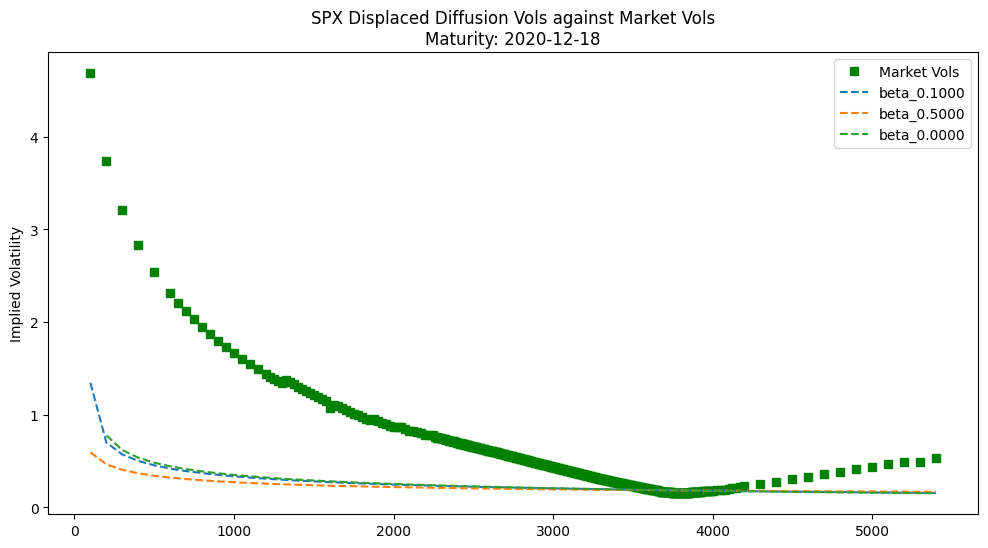

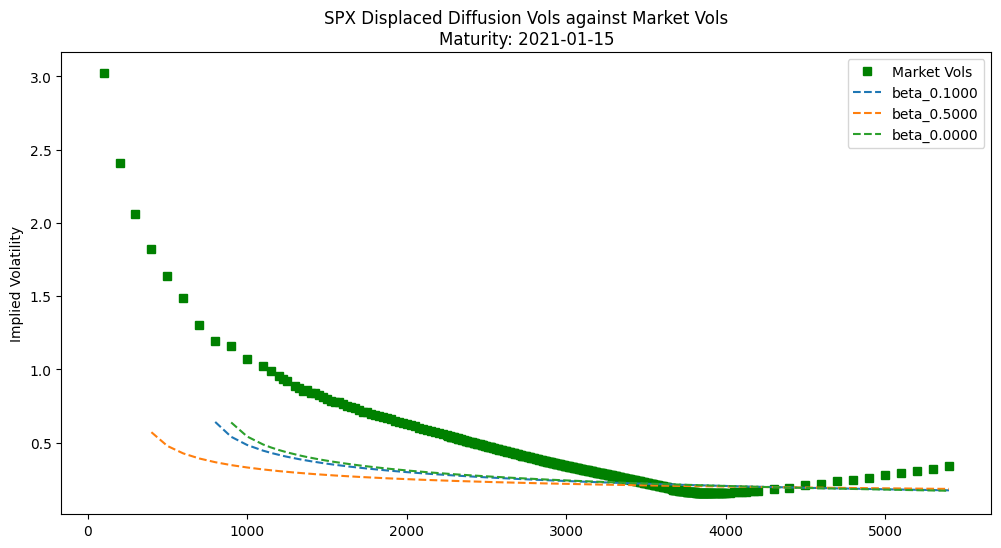

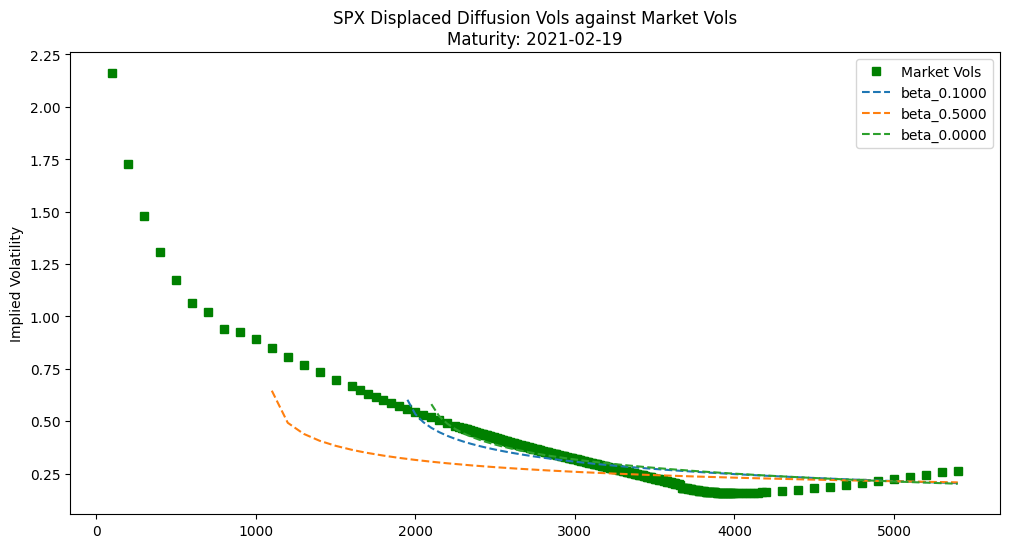

In [40]:
# Plot graph
# Unable to fit well to the graph because
# Greater weights placed by algorithm to fit ATM option, with strikes further away from ATM having minimal weights
# Beta parameter alone is insufficient to fit to the curve
# We plot additional beta values of 0.1 and 0.5 for comparison of fit

for date, vols in DD_SPX.items():
    plt.figure(figsize = (12,6))
    plt.plot(impliedvol_SPX[date]["strike"], impliedvol_SPX[date]["implied_vol"], 'gs', label='Market Vols')
    plt.plot(impliedvol_SPX[date]["strike"], vols.iloc[ : , 1: ], '--', label = vols.columns[1:])
    plt.title(f"SPX Displaced Diffusion Vols against Market Vols\nMaturity: {date.date()}")
    plt.ylabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.show()

#### SPY Options

In [41]:
# Get ATM option volatility for each ex-date
ATM_vols_SPY = {}
for date, vols in impliedvol_SPY.items():
    ATM_vols_SPY[date] = calculateATMVolatility(impliedvol_SPY[date], SPY_index_val)

ATM_vols_SPY

{Timestamp('2020-12-18 00:00:00'): 0.201551377306335,
 Timestamp('2021-01-15 00:00:00'): 0.19776672329638564,
 Timestamp('2021-02-19 00:00:00'): 0.20065268951322715}

In [42]:
# Estimated runtime is 2 minutes
# Fitting beta values using the least sqaures method
# Sigma value has been calibrated to ATM options

initialGuess = [0.7]
limits = [0,1]
option_day = dt.datetime(2020, 12, 1)
beta_DD_SPY = {}

for date, vols in impliedvol_SPY.items():
    days_diff = (date - option_day).days
    res = least_squares(lambda x: DisplacedDiffusionCalibration(SPY_index_val,
                                                                ATM_vols_SPY[date],
                                                                vols["strike"],
                                                                discount_rates.iloc[days_diff - 7]["rate"],
                                                                days_diff/365,
                                                                x,
                                                                vols["implied_vol"]),
                        initialGuess,
                        bounds = limits)
    beta_DD_SPY[date] = res.x[0]

In [43]:
beta_DD_SPY

{Timestamp('2020-12-18 00:00:00'): 4.430042613663914e-07,
 Timestamp('2021-01-15 00:00:00'): 6.27885947522708e-11,
 Timestamp('2021-02-19 00:00:00'): 1.2729690082685642e-07}

In [44]:
# Calculate implied volatility using DD model pricing
option_day = dt.datetime(2020, 12, 1)
DD_SPY = {}  

for date, vols in impliedvol_SPY.items():
    days_diff = (date - option_day).days
    r = discount_rates.iloc[days_diff - 7]["rate"]
    betas_list_SPY = [0.1, 0.5, beta_DD_SPY[date]]
    betas_SPY_df = pd.DataFrame()

    for beta in betas_list_SPY:
        DD_implied_vols =[]
        for K in vols["strike"]:
            if K > SPY_index_val:
                DD_option_price = DisplacedDiffusionCall(SPY_index_val,
                                                         ATM_vols_SPY[date],
                                                         K,
                                                         r,
                                                         days_diff,
                                                         beta)
                flag = "C"
            else:
                DD_option_price = DisplacedDiffusionPut(SPY_index_val,
                                                        ATM_vols_SPY[date],
                                                        K,
                                                        r,
                                                        days_diff,
                                                        beta)
                flag = "P"
            DD_implied_vols.append(getImpliedVolatility(SPY_index_val,
                                                        K,
                                                        r,
                                                        days_diff,
                                                        DD_option_price,
                                                        flag)
                                  )
        betas_SPY_df[f"beta_{beta:.4f}"] = DD_implied_vols
        
    DD_SPY[date] = pd.concat([vols["strike"], betas_SPY_df],
                             axis = 1)

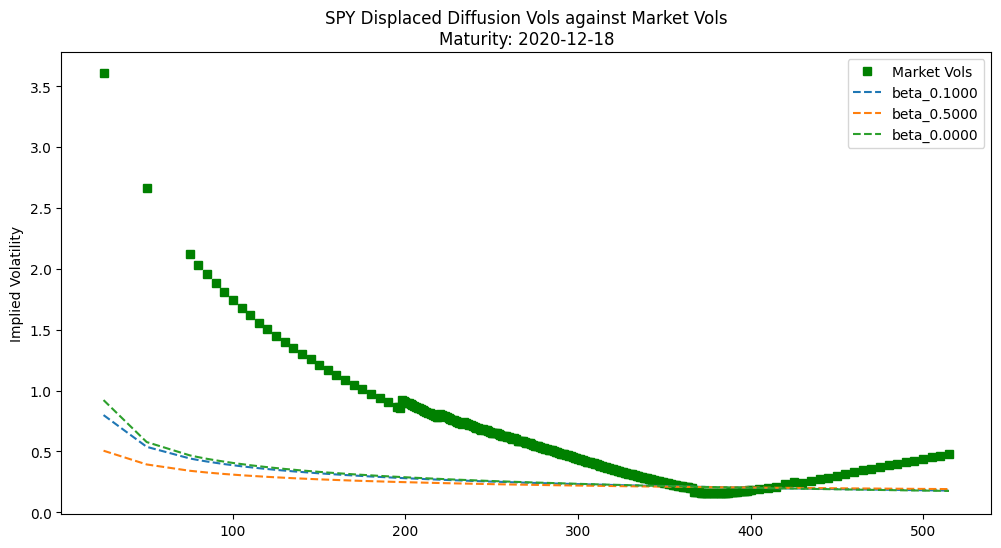

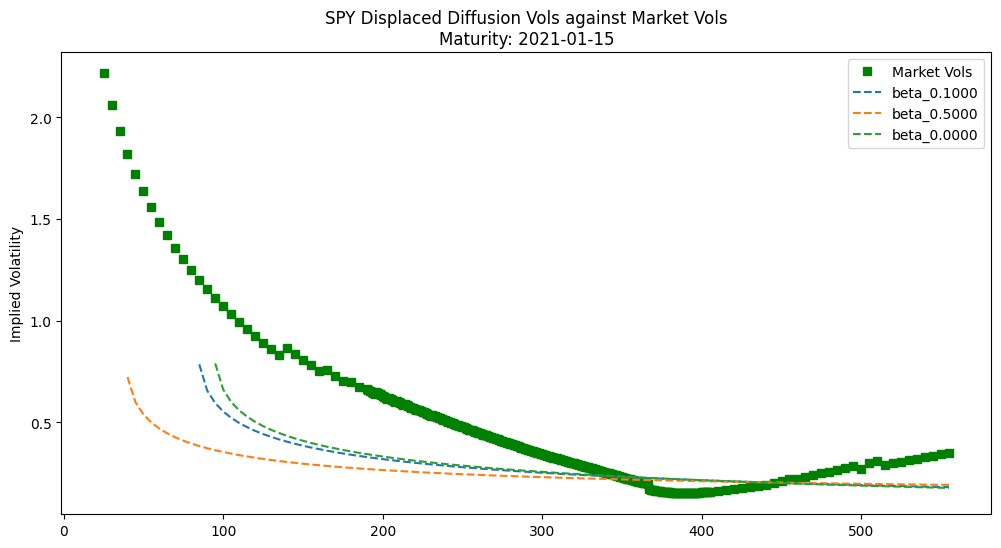

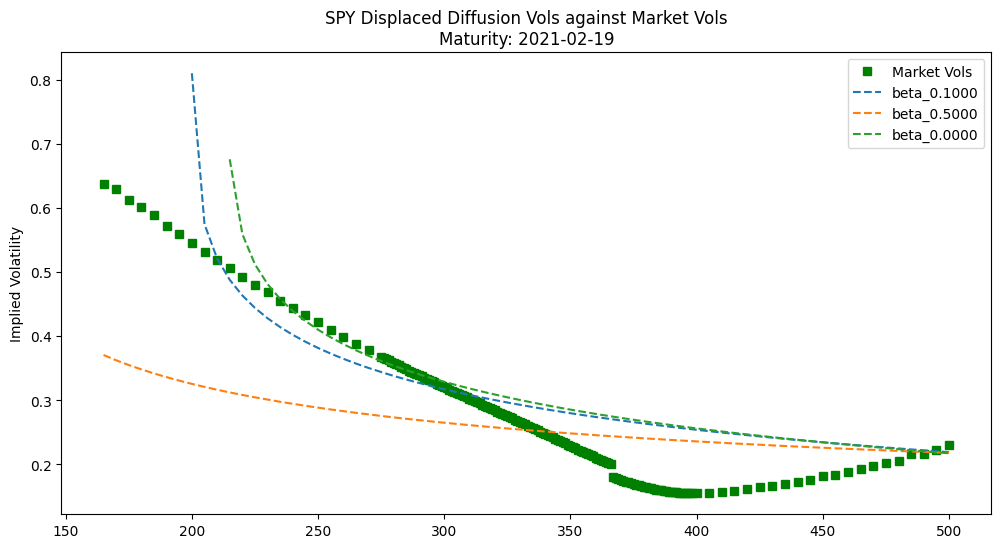

In [45]:
# Plot graph
# Unable to fit well to the graph because
# Greater weights placed by algorithm to fit ATM option, with strikes further away from ATM having minimal weights
# Beta parameter alone is insufficient to fit to the curve
# We plot additional beta values of 0.1 and 0.5 for comparison of fit

for date, vols in DD_SPY.items():
    plt.figure(figsize = (12,6))
    plt.plot(impliedvol_SPY[date]["strike"], impliedvol_SPY[date]["implied_vol"], 'gs', label='Market Vols')
    plt.plot(impliedvol_SPY[date]["strike"], vols.iloc[ : , 1: ], '--', label = vols.columns[1:])
    plt.title(f"SPY Displaced Diffusion Vols against Market Vols\nMaturity: {date.date()}")
    plt.ylabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.show()

### `SABR` Model Calibration

Stochastic Alpha Beta Rho, or SABR, model used to model the volatility smile in derivatives markets whereby both the underlying asset forward price and volatility are represented by stochastic state variables.

- Alpha represents the volatility of volatility and controls curvature of the curve
- Beta describes the sensitivity of forward price movements to the spot price and controls the slope of the implied skew
- Rho represents the instantaneous correlation between the underlying and its volatility and controls the slope of the implied skew

In this implementation, alpha and nu is used in place of sigma and alpha to emphasise the stochastic nature of volatility in the SABR model, given that most models assume sigma to be a constant. Beta is fixed with a value of 0.7. Similarly, least squares algorithm is used to calibrate the SABR model.

The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}

In [46]:
# Numerical approximation of SABR model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2)/24) * alpha * alpha/(F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha/(F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho)/24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T)/(F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha) * ((F * X) ** (0.5 * (1-beta))) * np.log(F/X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta) ** 2)/24) * ((alpha * alpha)/((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha/((F * X) ** ((1 - beta)/2))
        numer3 = ((2 - 3 * rho * rho)/24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2/24) * (np.log(F/X)) ** 2
        denom2 = (((1 - beta) ** 4)/1920) * ((np.log(F/X)) ** 4)
        denom = ((F*X) ** ((1 - beta)/2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer/denom

    return sabrsigma

In [47]:
def SABRCalibration(x, strikes, vols, F, T, beta):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F,
                           strikes[i],
                           T,
                           x[0],
                           beta,
                           x[1],
                           x[2])) ** 2

    return err

#### SPX Options

In [48]:
# Fitting SABR model parametes for alpha, rho and nu

initialGuess = [0.02, 0.2, 0.1]
option_day = dt.datetime(2020, 12, 1)
params_SABR_SPX = {}
beta = 0.7
sabr_SPX = {}

for date, vols in impliedvol_SPX.items():
    days_diff = (date - option_day).days
    F = SPX_index_val * np.exp(discount_rates.iloc[days_diff - 7]["rate"] * (days_diff/365))
    sabrvols = []
    
    res = least_squares(lambda x: SABRCalibration(x,
                                                  vols["strike"],
                                                  vols["implied_vol"],
                                                  F,
                                                  days_diff/365,
                                                  beta),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    params_SABR_SPX[date] = (alpha, beta, rho, nu)

    for K in vols["strike"]:
        sabrvols.append(SABR(F, K, days_diff/365, alpha, beta, rho, nu))
    sabr_SPX[date] = sabrvols

In [49]:
for date, param in params_SABR_SPX.items():
    print(f"Calibrated SABR model parameters ({date.date()}): "
          f"alpha = {param[0]:.3f}, beta = {param[1]:.3f}, rho = {param[2]:.3f} nu = {param[3]:.3f}")

Calibrated SABR model parameters (2020-12-18): alpha = 1.212, beta = 0.700, rho = -0.301 nu = 5.460
Calibrated SABR model parameters (2021-01-15): alpha = 1.817, beta = 0.700, rho = -0.404 nu = 2.790
Calibrated SABR model parameters (2021-02-19): alpha = 2.140, beta = 0.700, rho = -0.575 nu = 1.842


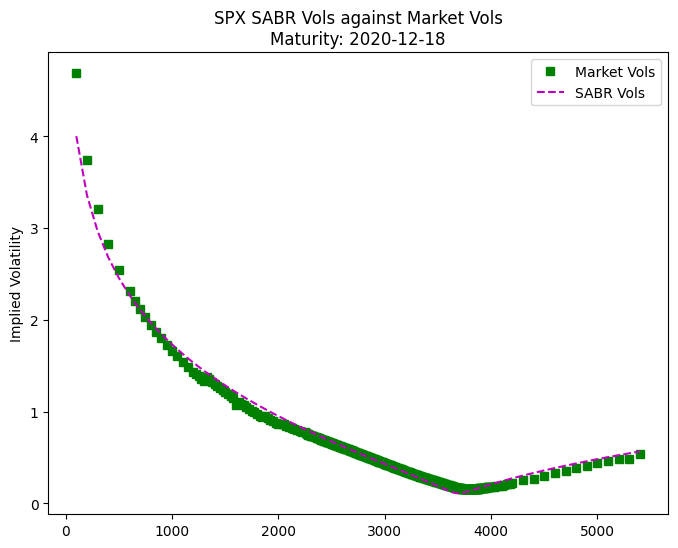

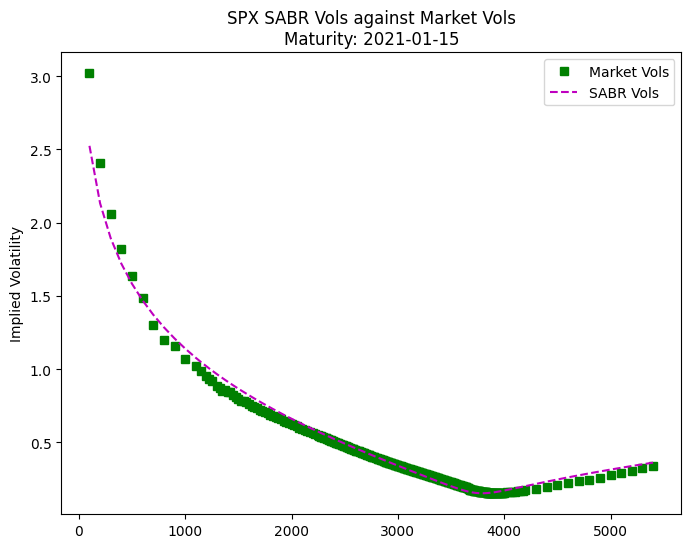

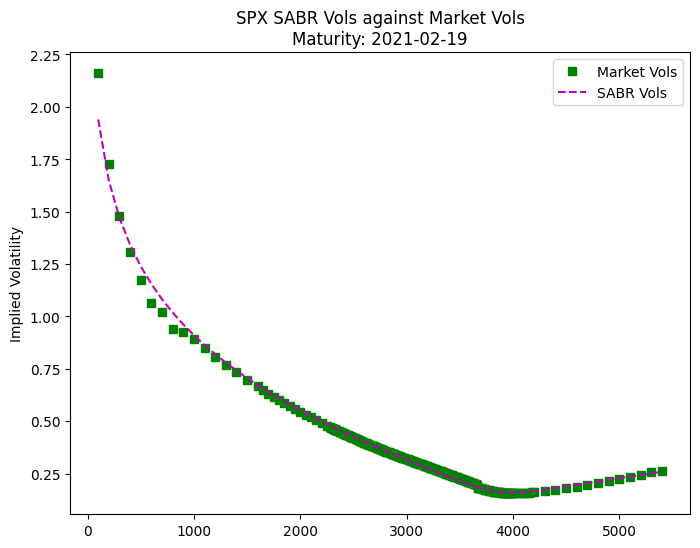

In [50]:
for date, vols in sabr_SPX.items():
    plt.figure(figsize = (8,6))
    plt.plot(impliedvol_SPX[date]["strike"], impliedvol_SPX[date]["implied_vol"], 'gs', label='Market Vols')
    plt.plot(impliedvol_SPX[date]["strike"], vols, 'm--', label='SABR Vols')
    plt.title(f"SPX SABR Vols against Market Vols\nMaturity: {date.date()}")
    plt.ylabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.show()

#### SPY Options

In [51]:
initialGuess = [0.02, 0.2, 0.1]
option_day = dt.datetime(2020, 12, 1)
params_SABR_SPY = {}
beta = 0.7
sabr_SPY = {}

for date, vols in impliedvol_SPY.items():
    days_diff = (date - option_day).days
    F = SPY_index_val * np.exp(discount_rates.iloc[days_diff - 7]["rate"] * (days_diff/365))
    sabrvols = []
    
    res = least_squares(lambda x: SABRCalibration(x,
                                                  vols["strike"],
                                                  vols["implied_vol"],
                                                  F,
                                                  days_diff/365,
                                                  beta),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    params_SABR_SPY[date] = (alpha, beta, rho, nu)

    for K in vols["strike"]:
        sabrvols.append(SABR(F, K, days_diff/365, alpha, beta, rho, nu))
    sabr_SPY[date] = sabrvols

In [52]:
for date, param in params_SABR_SPY.items():
    print(f"Calibrated SABR model parameters ({date.date()}): "
          f"alpha = {param[0]:.3f}, beta = {param[1]:.3f}, rho = {param[2]:.3f} nu = {param[3]:.3f}")

Calibrated SABR model parameters (2020-12-18): alpha = 0.665, beta = 0.700, rho = -0.412 nu = 5.250
Calibrated SABR model parameters (2021-01-15): alpha = 0.908, beta = 0.700, rho = -0.489 nu = 2.729
Calibrated SABR model parameters (2021-02-19): alpha = 1.121, beta = 0.700, rho = -0.633 nu = 1.742


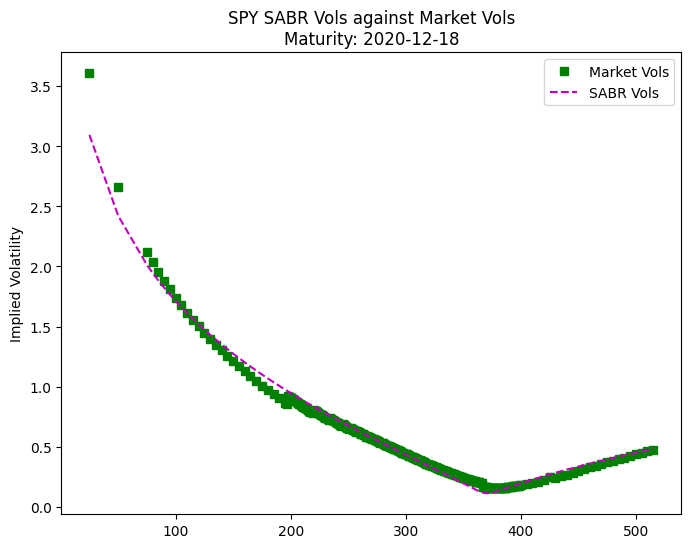

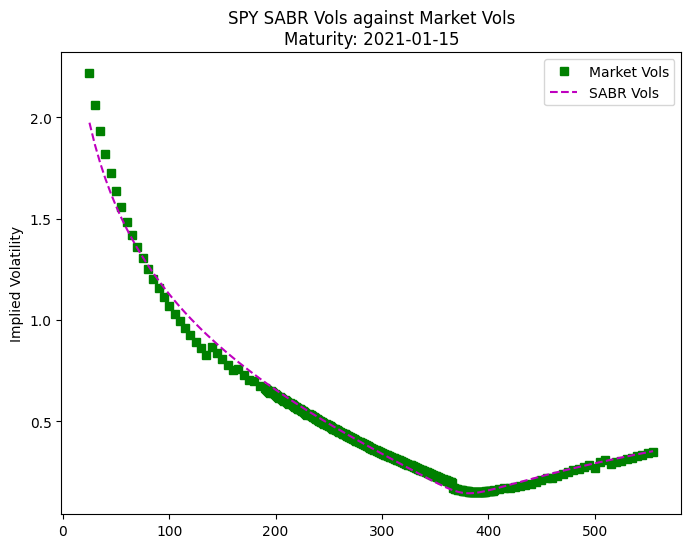

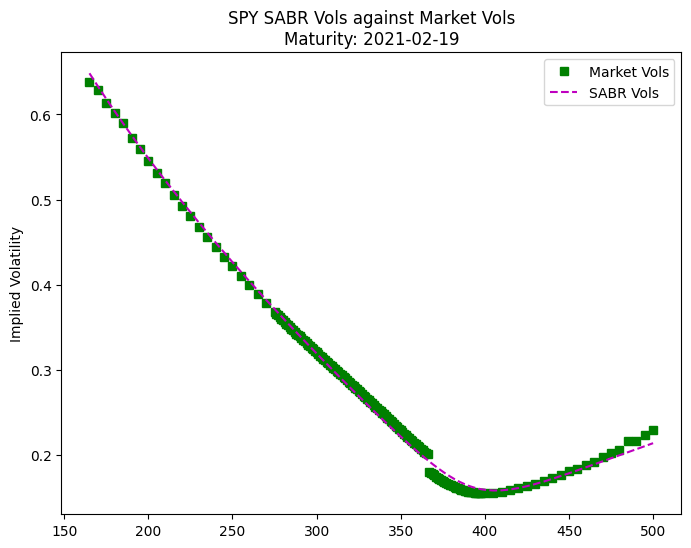

In [53]:
for date, vols in sabr_SPY.items():
    plt.figure(figsize = (8,6))
    plt.plot(impliedvol_SPY[date]["strike"], impliedvol_SPY[date]["implied_vol"], 'gs', label='Market Vols')
    plt.plot(impliedvol_SPY[date]["strike"], vols, 'm--', label='SABR Vols')
    plt.title(f"SPY SABR Vols against Market Vols\nMaturity: {date.date()}")
    plt.ylabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.show()

### Overall Results

Market implied volatilities for the 3 maturities is plotted together with the calculated volatilities from calibrated Displaced - Diffusion and SABR models to demonstrate model flexibility in fitting to the market volatility smile. It can be observed that the further away the maturity, the flatter the smile as investors believe that the market will revert to the long run average for the underlying. However in the short term, anything can happen and options are used especially to insure against unexpected downside resulting in a more pronounced smile. 

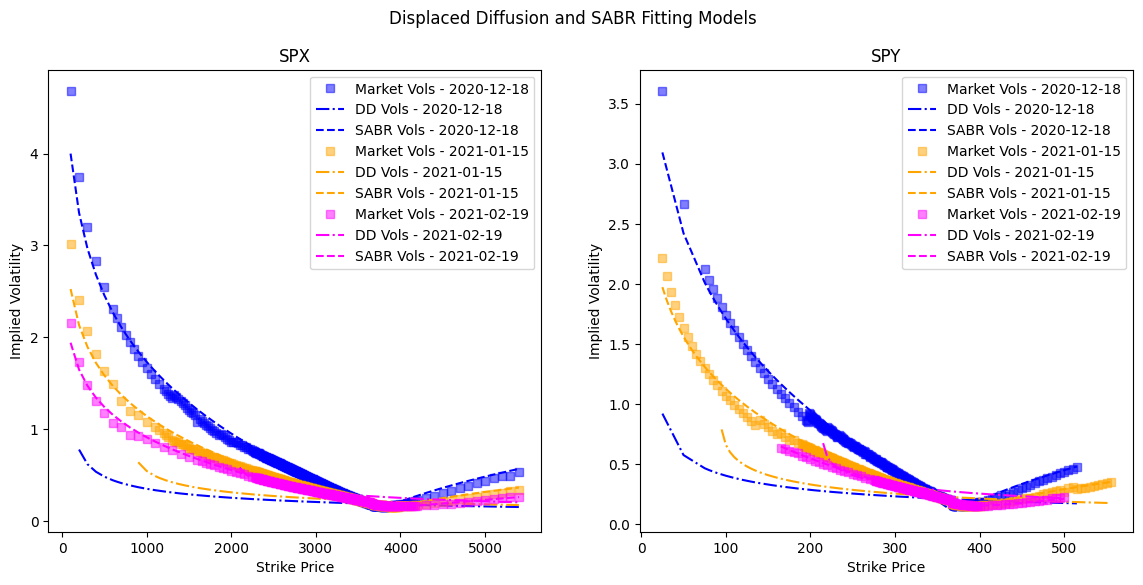

In [54]:
# Create subplots
dates_list = list(pd.to_datetime(SPX_options["exdate"].unique()))
colours = ["blue", "orange", "magenta"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # First set of plots (SPX)
for i, date in enumerate(dates_list):
    axes[0].plot(impliedvol_SPX[date]["strike"],
                 impliedvol_SPX[date]["implied_vol"],
                 's',
                 c = colours[i],
                 alpha = 0.5,
                 label=f'Market Vols - {date.date()}')
    axes[0].plot(impliedvol_SPX[date]["strike"],
                 DD_SPX[date]["beta_0.0000"],
                 '-.',
                 c = colours[i],
                 label = f'DD Vols - {date.date()}')
    axes[0].plot(impliedvol_SPX[date]["strike"],
                 sabr_SPX[date],
                 '--',
                 c = colours[i],
                 label= f'SABR Vols - {date.date()}')

axes[0].set_title('SPX')
axes[0].set_xlabel('Strike Price')
axes[0].set_ylabel('Implied Volatility')
axes[0].legend()

# # First set of plots (SPy)
for i, date in enumerate(dates_list):
    axes[1].plot(impliedvol_SPY[date]["strike"],
                 impliedvol_SPY[date]["implied_vol"],
                 's',
                 c = colours[i],
                 alpha = 0.5,
                 label=f'Market Vols - {date.date()}')
    axes[1].plot(impliedvol_SPY[date]["strike"],
                 DD_SPY[date]["beta_0.0000"],
                 '-.',
                 c = colours[i],
                 label = f'DD Vols - {date.date()}')
    axes[1].plot(impliedvol_SPY[date]["strike"],
                 sabr_SPY[date],
                 '--',
                 c = colours[i],
                 label= f'SABR Vols - {date.date()}')

axes[1].set_title('SPY')
axes[1].set_xlabel('Strike Price')
axes[1].set_ylabel('Implied Volatility')
axes[1].legend()

plt.suptitle("Displaced Diffusion and SABR Fitting Models")
plt.show()